In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import pearsonr

In [2]:
diagnoses_df = pd.read_csv('cleaned_D_ICD_DIAGNOSES.csv')
patients_df = pd.read_csv('cleaned_PATIENTS.csv')
prescriptions_df = pd.read_csv('cleaned_PRESCRIPTIONS.csv', low_memory=False)

In [3]:
diagnoses_df.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,tb pneumonia-oth test,"tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,tb pneumothorax-unspec,"tuberculous pneumothorax, unspecified"
2,176,01171,tb pneumothorax-no exam,"tuberculous pneumothorax, bacteriological or h..."
3,177,01172,tb pneumothorx-exam unkn,"tuberculous pneumothorax, bacteriological or h..."
4,178,01173,tb pneumothorax-micro dx,"tuberculous pneumothorax, tubercle bacilli fou..."


In [4]:
patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaN,NaN,NaN,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15,NaN,NaN,NaN,0
3,237,252,M,2078-03-06,NaN,NaN,NaN,0
4,238,253,F,2089-11-26,NaN,NaN,NaN,0


In [5]:
prescriptions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11,2175-06-12,MAIN,tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,469061711.0,1mg Capsule,2.0,mg,2,CAP,po
1,2214775,6,107064,NaN,2175-06-11,2175-06-12,MAIN,warfarin,Warfarin,Warfarin,WARF5,006562,56017275.0,5mg Tablet,5.0,mg,1,TAB,po
2,2216265,6,107064,NaN,2175-06-11,2175-06-12,BASE,d5w,NaN,NaN,HEPBASE,NaN,0.0,HEPARIN BASE,250.0,ml,250,ml,iv
3,2214773,6,107064,NaN,2175-06-11,2175-06-12,MAIN,furosemide,Furosemide,Furosemide,FURO20,008208,54829725.0,20mg Tablet,20.0,mg,1,TAB,po
4,2214774,6,107064,NaN,2175-06-11,2175-06-15,MAIN,warfarin,Warfarin,Warfarin,WARF0,014198,56016975.0,Check with MD for Dose,1.0,dose,1,dose,po


In [6]:
prescriptions_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTDATE', 'ENDDATE',
       'DRUG_TYPE', 'DRUG', 'DRUG_NAME_POE', 'DRUG_NAME_GENERIC',
       'FORMULARY_DRUG_CD', 'GSN', 'NDC', 'PROD_STRENGTH', 'DOSE_VAL_RX',
       'DOSE_UNIT_RX', 'FORM_VAL_DISP', 'FORM_UNIT_DISP', 'ROUTE'],
      dtype='object')

In [7]:
prescriptions_df["DRUG"].nunique()

3798

In [8]:
prescriptions_df["DRUG_TYPE"].describe()

count     3859168
unique          3
top          MAIN
freq      2930412
Name: DRUG_TYPE, dtype: object

In [9]:
prescriptions_df["DRUG_NAME_GENERIC"].nunique()

2832

In [10]:
prescriptions_df["DRUG_NAME_POE"].nunique()


3916

In [11]:
prescriptions_df["FORMULARY_DRUG_CD"].nunique()


3241

In [12]:
prescriptions_df['STARTDATE'] = pd.to_datetime(prescriptions_df['STARTDATE'])
prescriptions_df['ENDDATE'] = pd.to_datetime(prescriptions_df['ENDDATE'])
prescriptions_df['DURATION'] = (prescriptions_df['ENDDATE'] - prescriptions_df['STARTDATE']).dt.days

# Merge datasets
merged_df = pd.merge(patients_df[['SUBJECT_ID', 'EXPIRE_FLAG']], prescriptions_df[['SUBJECT_ID', 'DRUG_NAME_GENERIC', 'DRUG_TYPE', 'DRUG', 'DURATION', 'NDC']], on='SUBJECT_ID')

# Start cleaning the data + make new dataset csv

In [13]:
merged_df.isna().sum()

SUBJECT_ID                 0
EXPIRE_FLAG                0
DRUG_NAME_GENERIC    1595328
DRUG_TYPE                  0
DRUG                       0
DURATION                   0
NDC                     3057
dtype: int64

In [14]:
# Drop all nan values in NDC
merged_df.dropna(subset=['NDC'], inplace=True)
merged_df.shape

(3856111, 7)

In [15]:
merged_df.dtypes

SUBJECT_ID             int64
EXPIRE_FLAG            int64
DRUG_NAME_GENERIC     object
DRUG_TYPE             object
DRUG                  object
DURATION               int64
NDC                  float64
dtype: object

In [16]:
# Convert to int (get rid of .0)
merged_df['NDC'] = merged_df['NDC'].astype(int)

# Convert to String
merged_df['NDC'] = merged_df['NDC'].astype(str)

# Pad with leading zeros to ensure length is 10
merged_df['NDC'] = merged_df['NDC'].apply(lambda x: x.zfill(10))

# Count entries of length 11
entries_length_11 = merged_df[merged_df['NDC'].str.len() == 11].shape[0]

# Drop entries of length 11
merged_df = merged_df[merged_df['NDC'].str.len() <= 10]

print(f"Number of entries of length 11 and dropped: {entries_length_11}")

Number of entries of length 11 and dropped: 928315


In [17]:
merged_df.head()

,SUBJECT_ID,EXPIRE_FLAG,DRUG_NAME_GENERIC,DRUG_TYPE,DRUG,DURATION,NDC
0,249,0,Trandolapril,MAIN,trandolapril,0,0074227811
1,249,0,NaN,BASE,d5w,1,0000000000
2,249,0,NaN,MAIN,vancomycin hcl,1,0002735501
3,249,0,NaN,BASE,iso-osmotic dextrose,1,0000000000
4,249,0,Captopril,MAIN,captopril,2,0003045051


In [18]:
# ensure it's a copy to avoid SettingWithCopyWarning
merged_df = merged_df.copy()

# convert codes into xxxx-xxxx-xx format
merged_df['NDC'] = merged_df['NDC'].apply(lambda x: f"{x[:4]}-{x[4:8]}-{x[8:]}")

In [19]:
merged_df["NDC"].describe()

count          2927796
unique            2615
top       0000-0000-00
freq            577126
Name: NDC, dtype: object

In [20]:
merged_df.shape

(2927796, 7)

In [21]:
merged_df.head()

,SUBJECT_ID,EXPIRE_FLAG,DRUG_NAME_GENERIC,DRUG_TYPE,DRUG,DURATION,NDC
0,249,0,Trandolapril,MAIN,trandolapril,0,0074-2278-11
1,249,0,NaN,BASE,d5w,1,0000-0000-00
2,249,0,NaN,MAIN,vancomycin hcl,1,0002-7355-01
3,249,0,NaN,BASE,iso-osmotic dextrose,1,0000-0000-00
4,249,0,Captopril,MAIN,captopril,2,0003-0450-51


In [22]:
drug_code = pd.read_csv("ndc_map 2020_06_17 (atc5 atc4 ingredients).csv", low_memory=False)
drug_code.head()

,ndc,rxcui,atc4,atc4_name,in_rxcui,has_min,in_tty,in_name,in_synonym,in_umlscui,atc5,ddd,u,adm_r,whocc_note
0,0002-0800-01,540930.0,NaN,NaN,11295.0,False,IN,water,NaN,C0043047,NaN,NaN,NaN,NaN,NaN
1,0002-1200-30,1716302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0002-1200-50,1716302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0002-1210-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0002-1210-50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
merged_df = pd.merge(merged_df, drug_code, left_on='NDC', right_on='ndc', how='left')

In [24]:
merged_df.shape

(6943995, 22)

In [25]:
merged_df.isna().sum()

SUBJECT_ID                 0
EXPIRE_FLAG                0
DRUG_NAME_GENERIC    4882486
DRUG_TYPE                  0
DRUG                       0
DURATION                   0
NDC                        0
ndc                  1598596
rxcui                1598596
atc4                 1820929
atc4_name            1820929
in_rxcui             1602622
has_min              1602622
in_tty               1602622
in_name              1602622
in_synonym           6568423
in_umlscui           1602622
atc5                 3182837
ddd                  6912707
u                    6912707
adm_r                6912707
whocc_note           6943990
dtype: int64

In [26]:
merged_df.dropna(subset=["atc4", "atc4_name", 'atc5'], inplace=True)

In [27]:
merged_df.shape

(3761158, 22)

In [28]:
merged_df.drop(["ndc", "ddd", "u", "adm_r", "whocc_note"], axis=1, inplace=True, errors='ignore')

In [29]:
merged_df.isna().sum()

SUBJECT_ID                 0
EXPIRE_FLAG                0
DRUG_NAME_GENERIC    2930623
DRUG_TYPE                  0
DRUG                       0
DURATION                   0
NDC                        0
rxcui                      0
atc4                       0
atc4_name                  0
in_rxcui                   0
has_min                    0
in_tty                     0
in_name                    0
in_synonym           3736047
in_umlscui                 0
atc5                       0
dtype: int64

In [30]:
merged_df.shape

(3761158, 17)

In [31]:
merged_df.head()

,SUBJECT_ID,EXPIRE_FLAG,DRUG_NAME_GENERIC,DRUG_TYPE,DRUG,DURATION,NDC,rxcui,atc4,atc4_name,in_rxcui,has_min,in_tty,in_name,in_synonym,in_umlscui,atc5
12,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,A12CA,Sodium,9863.0,False,IN,sodium chloride,NaN,C0037494,A12CA01
13,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,B05CB,Salt solutions,9863.0,False,IN,sodium chloride,NaN,C0037494,B05CB01
14,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,B05XA,Electrolyte solutions,9863.0,False,IN,sodium chloride,NaN,C0037494,B05XA03
16,249,0,NaN,MAIN,humulin-r insulin,1,0002-8215-01,311036.0,A10AB,"Insulins and analogues for injection, fast-acting",253182.0,False,IN,"insulin, regular, human",NaN,C0795635,A10AB01
17,249,0,NaN,MAIN,humulin-r insulin,1,0002-8215-01,311036.0,A10AC,"Insulins and analogues for injection, intermed...",253182.0,False,IN,"insulin, regular, human",NaN,C0795635,A10AC01


In [32]:
merged_df["SUBJECT_ID"].nunique()

37619

In [33]:
merged_df['atc3'] = merged_df['atc4'].str[:4]
merged_df['atc2'] = merged_df['atc4'].str[:3]
merged_df['atc1'] = merged_df['atc4'].str[0]

In [34]:
print(merged_df["atc5"].nunique())
print(merged_df["atc4"].nunique())
print(merged_df["atc3"].nunique())
print(merged_df["atc2"].nunique())
print(merged_df["atc1"].nunique())

611
312
141
73
14


In [35]:
merged_df["atc4_name"].nunique()

287

In [36]:
merged_df.to_csv('./cleaned_drug_atc_expire.csv', index=False)


---

# Read new cleaned df

In [37]:
drug_expire = pd.read_csv('cleaned_drug_atc_expire.csv')

In [38]:
drug_expire.head()

,SUBJECT_ID,EXPIRE_FLAG,DRUG_NAME_GENERIC,DRUG_TYPE,DRUG,DURATION,NDC,rxcui,atc4,atc4_name,in_rxcui,has_min,in_tty,in_name,in_synonym,in_umlscui,atc5,atc3,atc2,atc1
0,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,A12CA,Sodium,9863.0,False,IN,sodium chloride,NaN,C0037494,A12CA01,A12C,A12,A
1,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,B05CB,Salt solutions,9863.0,False,IN,sodium chloride,NaN,C0037494,B05CB01,B05C,B05,B
2,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,B05XA,Electrolyte solutions,9863.0,False,IN,sodium chloride,NaN,C0037494,B05XA03,B05X,B05,B
3,249,0,NaN,MAIN,humulin-r insulin,1,0002-8215-01,311036.0,A10AB,"Insulins and analogues for injection, fast-acting",253182.0,False,IN,"insulin, regular, human",NaN,C0795635,A10AB01,A10A,A10,A
4,249,0,NaN,MAIN,humulin-r insulin,1,0002-8215-01,311036.0,A10AC,"Insulins and analogues for injection, intermed...",253182.0,False,IN,"insulin, regular, human",NaN,C0795635,A10AC01,A10A,A10,A


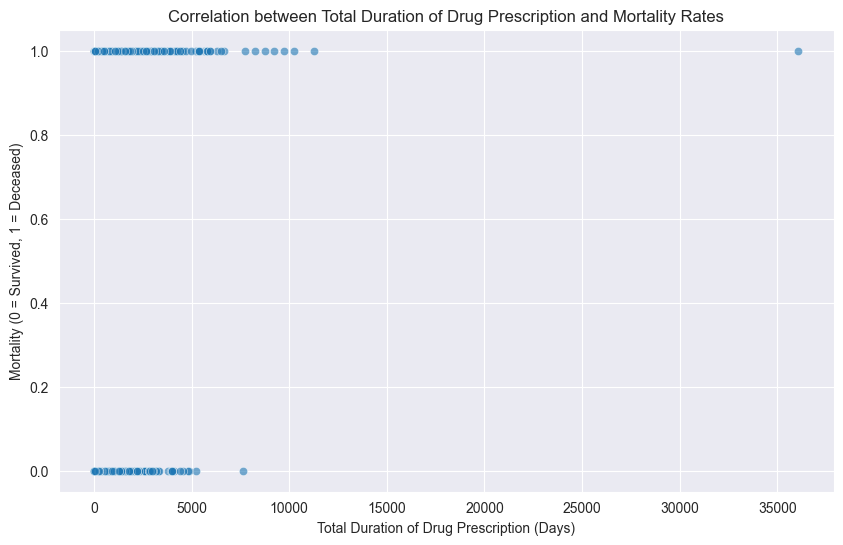

0.12641865829313695

In [39]:
# Aggregate the total duration of drug prescriptions per patient
patient_duration = drug_expire.groupby('SUBJECT_ID')['DURATION'].sum().reset_index()

# Merge this with the mortality flag to get a dataframe suitable for correlation analysis
mortality_duration = patient_duration.merge(drug_expire[['SUBJECT_ID', 'EXPIRE_FLAG']].drop_duplicates(), on='SUBJECT_ID')

# Scatter plot for correlation between the total duration of drug prescription and mortality rates
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mortality_duration, x='DURATION', y='EXPIRE_FLAG', alpha=0.6)
plt.title('Correlation between Total Duration of Drug Prescription and Mortality Rates')
plt.xlabel('Total Duration of Drug Prescription (Days)')
plt.ylabel('Mortality (0 = Survived, 1 = Deceased)')
plt.grid(True)
plt.show()

# Calculate the correlation coefficient for duration and expire flag
correlation_coef = mortality_duration['DURATION'].corr(mortality_duration['EXPIRE_FLAG'])
correlation_coef

In [40]:
drug_expire.columns

Index(['SUBJECT_ID', 'EXPIRE_FLAG', 'DRUG_NAME_GENERIC', 'DRUG_TYPE', 'DRUG',
       'DURATION', 'NDC', 'rxcui', 'atc4', 'atc4_name', 'in_rxcui', 'has_min',
       'in_tty', 'in_name', 'in_synonym', 'in_umlscui', 'atc5', 'atc3', 'atc2',
       'atc1'],
      dtype='object')

## Boxplot of total duration of drug prescriptions for EXPIRE_FLAG

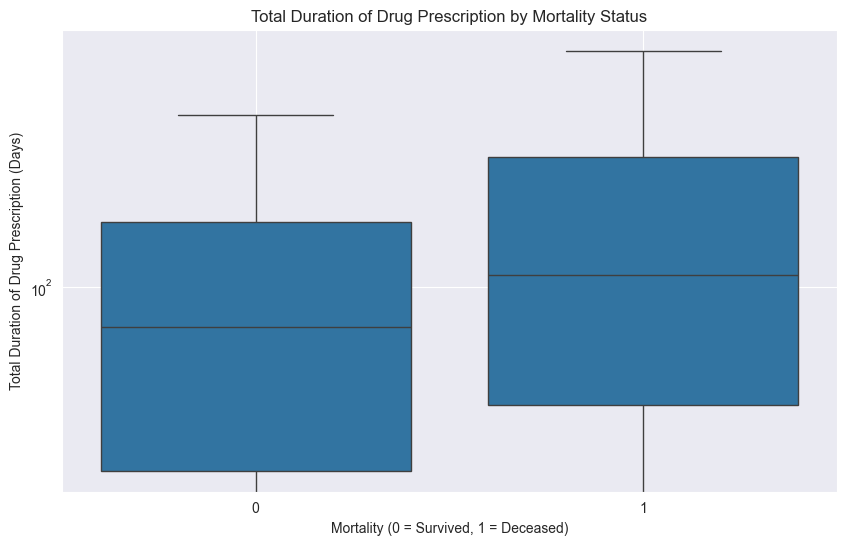

In [41]:
# Aggregate the total duration of drug prescriptions per patient
patient_duration = drug_expire.groupby('SUBJECT_ID')['DURATION'].sum().reset_index()

# Merge this with the mortality flag to get a dataframe suitable for correlation analysis
mortality_duration = patient_duration.merge(drug_expire[['SUBJECT_ID', 'EXPIRE_FLAG']].drop_duplicates(), on='SUBJECT_ID')

# Create a boxplot with log scale
plt.figure(figsize=(10, 6))
sns.boxplot(data=mortality_duration, x='EXPIRE_FLAG', y='DURATION', showfliers=False)
plt.yscale('log')  # Set y-axis to log scale
plt.title('Total Duration of Drug Prescription by Mortality Status')
plt.xlabel('Mortality (0 = Survived, 1 = Deceased)')
plt.ylabel('Total Duration of Drug Prescription (Days)')
plt.grid(True)
plt.show()

In [42]:
mortality_duration.describe()

,SUBJECT_ID,DURATION,EXPIRE_FLAG
count,37619.000000,37619.000000,37619.000000
mean,38959.685957,195.286079,0.373030
std,29324.019556,421.750511,0.483616
min,4.000000,0.000000,0.000000
25%,14586.000000,30.000000,0.000000
50%,28802.000000,84.000000,0.000000
75%,63694.000000,202.000000,1.000000
max,99999.000000,36078.000000,1.000000


In [43]:
drug_class = 'atc1'

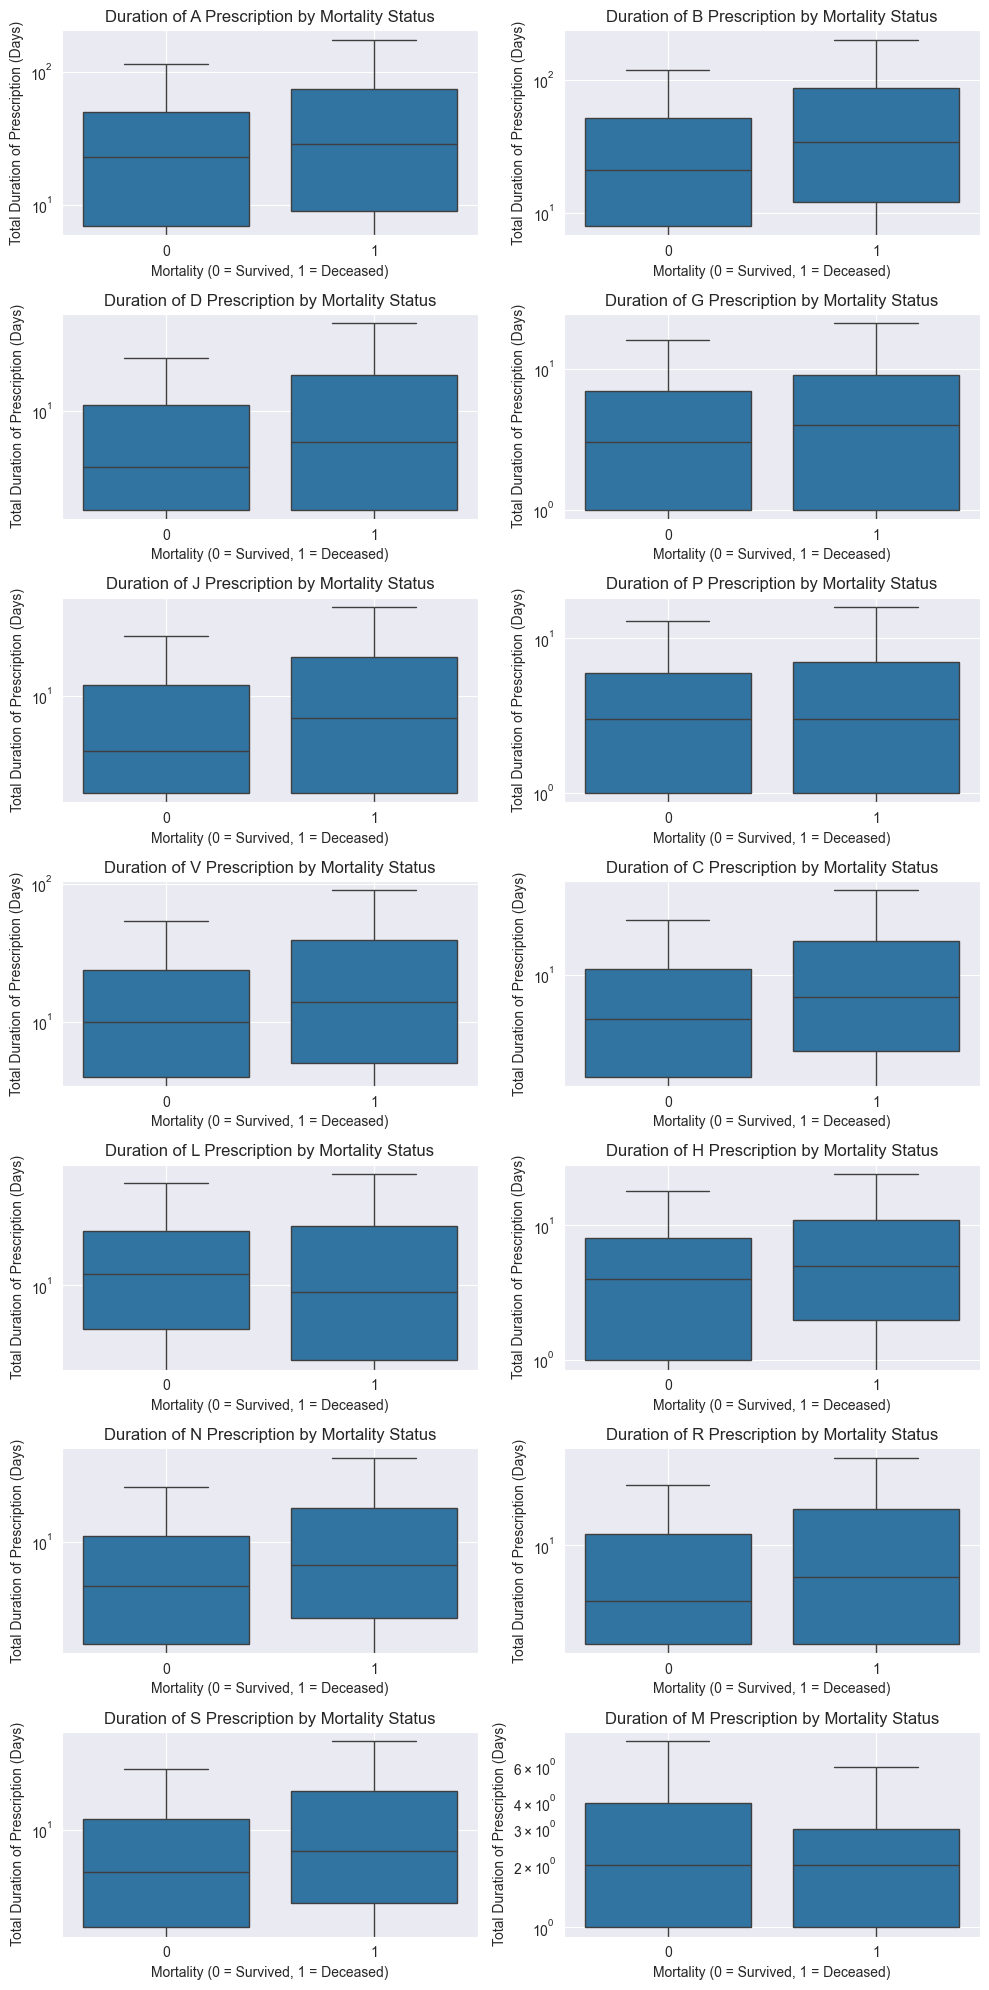

In [44]:
# Aggregate Total Duration
drug_type_duration = drug_expire.groupby(['SUBJECT_ID', drug_class])['DURATION'].sum().reset_index()

# Merge with Mortality Flag
mortality_drug_type = drug_type_duration.merge(drug_expire[['SUBJECT_ID', 'EXPIRE_FLAG']].drop_duplicates(), on='SUBJECT_ID')

# Plot setup
plt.figure(figsize=(10, 20))

# Create Boxplots
for i, drug_type in enumerate(mortality_drug_type[drug_class].unique(), start=1):
    plt.subplot(7, 2, i)  # Adjust subplot grid as necessary
    sns.boxplot(data=mortality_drug_type[mortality_drug_type[drug_class] == drug_type], 
                x='EXPIRE_FLAG', y='DURATION', showfliers=False)
    plt.yscale('log')
    plt.title(f'Duration of {drug_type} Prescription by Mortality Status')
    plt.xlabel('Mortality (0 = Survived, 1 = Deceased)')
    plt.ylabel('Total Duration of Prescription (Days)')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Mortality rate by drug type based on prescription count

In [45]:
# Grouping the data by 'SUBJECT_ID' and 'DRUG_NAME_GENERIC' to aggregate the total duration and count the prescriptions
drug_patient_summary = drug_expire.groupby(['SUBJECT_ID', drug_class]).agg(
    Total_Duration=('DURATION', 'sum'),
    Prescription_Count=('atc4', 'count')
).reset_index()

# Merging the summary data back with the original to include 'EXPIRE_FLAG'
drug_patient_complete = pd.merge(
    drug_patient_summary,
    drug_expire[['SUBJECT_ID', drug_class, 'EXPIRE_FLAG']].drop_duplicates(),
    on=['SUBJECT_ID', drug_class],
    how='left'
)

# Selecting the top most frequently prescribed drugs
top_drugs = drug_patient_complete[drug_class].value_counts().head(40).index.tolist()

# Filter the dataset to include only the top drugs
top_drugs_df = drug_patient_complete[drug_patient_complete[drug_class].isin(top_drugs)]

# Aggregate data by drug and mortality flag, summing the total duration and counting the number of prescriptions
drug_mortality_summary = top_drugs_df.groupby([drug_class, 'EXPIRE_FLAG']).agg(
    Total_Duration=('Total_Duration', 'sum'),
    Prescription_Count=('Prescription_Count', 'sum')
).unstack(fill_value=0)

# Calculate the mortality rate 
drug_mortality_summary['Mortality Rate'] = drug_mortality_summary[('Prescription_Count', 1)] / (
    drug_mortality_summary[('Prescription_Count', 0)] + drug_mortality_summary[('Prescription_Count', 1)]
)

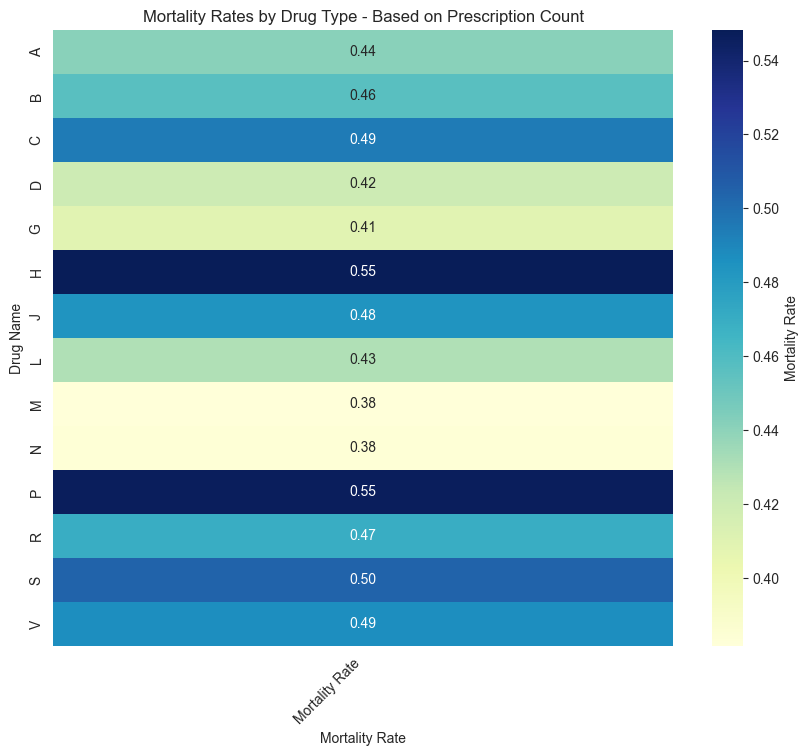

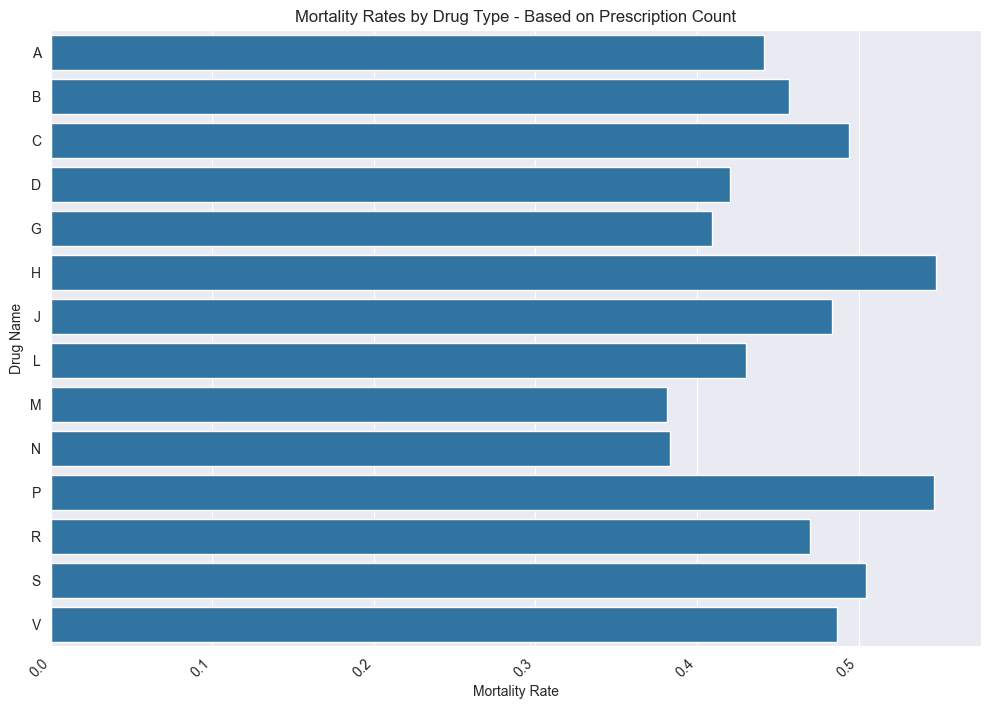

In [46]:
# Preparing data for the visualizations
heatmap_data = drug_mortality_summary[['Mortality Rate']].reset_index()
heatmap_data.columns = [drug_class, 'Mortality Rate']
heatmap_data.set_index(drug_class, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data=heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mortality Rate'}, fmt=".2f")
plt.title('Mortality Rates by Drug Type - Based on Prescription Count')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plotting the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Mortality Rate', y=drug_class, data=heatmap_data.reset_index())
plt.title('Mortality Rates by Drug Type - Based on Prescription Count')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

## Mortality rate by drug type based on patient count

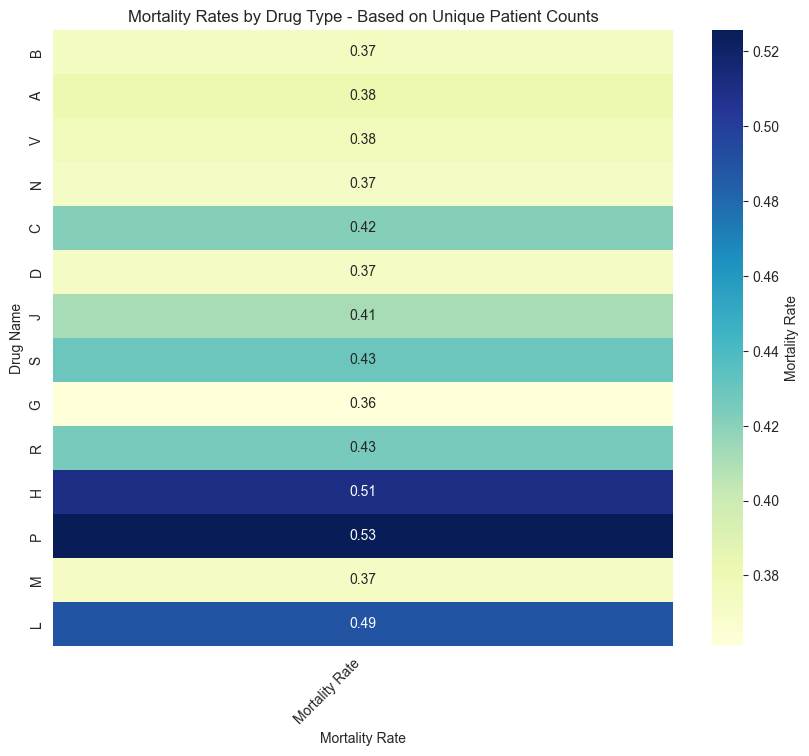

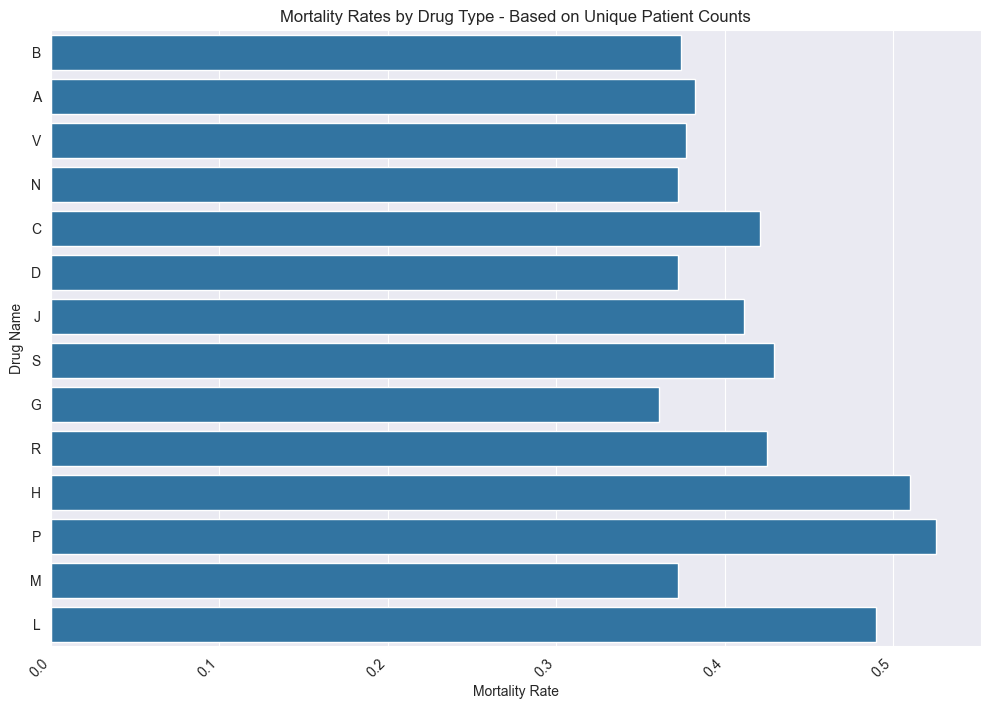

In [47]:
# calculating unique patients per drug
unique_patient_drug_expire = drug_patient_complete.groupby([drug_class, 'EXPIRE_FLAG'])['SUBJECT_ID'].nunique().unstack(fill_value=0)

# Calculate the new mortality rate based on unique patient counts
unique_patient_drug_expire['Mortality Rate'] = unique_patient_drug_expire[1] / (unique_patient_drug_expire[0] + unique_patient_drug_expire[1])

# Preparing the visualization data, focusing on the top drugs
new_heatmap_data = unique_patient_drug_expire.loc[top_drugs, ['Mortality Rate']]

# Plotting the heatmap for the updated mortality rates
plt.figure(figsize=(10, 8))
sns.heatmap(data=new_heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mortality Rate'}, fmt=".2f")
plt.title('Mortality Rates by Drug Type - Based on Unique Patient Counts')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plotting the bar chart for the updated mortality rates
plt.figure(figsize=(12, 8))
sns.barplot(x='Mortality Rate', y=new_heatmap_data.reset_index()[drug_class], data=new_heatmap_data.reset_index())
plt.title('Mortality Rates by Drug Type - Based on Unique Patient Counts')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

# Correlations

In [48]:
# Calculate Pearson's correlation coefficient between duration and mortality status
correlation_coef, p_value = pearsonr(mortality_duration['DURATION'], mortality_duration['EXPIRE_FLAG'])

print(f"Pearson's correlation coefficient: {correlation_coef}, P-value: {p_value}")

Pearson's correlation coefficient: 0.12641865829317547, P-value: 8.168377736423415e-134


In [49]:
mortality_duration[["DURATION", "EXPIRE_FLAG"]].corr(method='pearson')

,DURATION,EXPIRE_FLAG
DURATION,1.000000,0.126419
EXPIRE_FLAG,0.126419,1.000000


### Cramer's V Results
Cramer's V is a measure of association between two categorical variables, giving a value between 0 and 1. This statistic tells you how strongly two categorical variables are associated. Values close to 0 indicate a weak association, while values closer to 1 indicate a strong association.

In [50]:
from scipy.stats import chi2_contingency

def cramers_v_and_p_value(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p_value, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    cramers_v = np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))
    return cramers_v, p_value

# Calculate Cramér's V and p-values between EXPIRE_FLAG and categorical variables
results = {}
for col in ['atc1', 'atc2', 'atc3', 'atc4', 'atc5']:
    results[col] = cramers_v_and_p_value(drug_expire['EXPIRE_FLAG'], drug_expire[col])

# Display Cramér's V and p-value results
print("Cramér's V and p-value Results for Categorical Variables:")
for k, v in results.items():
    print(f"{k}: Cramér's V = {v[0]:.4f}, p-value = {v[1]:.4f}")

Cramér's V and p-value Results for Categorical Variables:
atc1: Cramér's V = 0.0516, p-value = 0.0000
atc2: Cramér's V = 0.0904, p-value = 0.0000
atc3: Cramér's V = 0.1109, p-value = 0.0000
atc4: Cramér's V = 0.1292, p-value = 0.0000
atc5: Cramér's V = 0.1448, p-value = 0.0000


The Cramér's V results indicate statistically significant but generally weak associations between the EXPIRE_FLAG and the ATC levels (atc1 to atc5), with Cramér's V values ranging from 0.0516 to 0.1448. This suggests that while there is some degree of association between the specificity of drug categories and patient outcomes, the practical significance of these associations may be limited (due to low Cramér's values). Notably, the gradual increase in Cramér's V values from atc1 through atc5 hints at a slightly stronger relationship with more specific drug categorizations, suggesting a potential for these variables to contribute to understanding patient outcomes when used in conjunction with other data. However, the practical implications of these weak associations should be carefully considered, and further research might explore more detailed interactions or additional variables that could reveal stronger or more nuanced relationships